# 期中報告

## 1. 引入套件

In [1]:
from datetime import datetime
from collections import Counter

import jieba
import jieba.analyse
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import math
import re
from nltk import ngrams
from nltk import FreqDist
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from collections import Counter, namedtuple

In [2]:
# 設定圖的字體
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 機車版(biker)文章
+ 關鍵字:「電動機車、電動車、機車選購、充電、保養、優惠、服務、折扣」
+ 時間: 2020-01-01 ~ 2023-04-12
+ 資料筆數：共 1517 篇文章

In [3]:
#匯入資料
df = pd.read_csv('rawData/Japan_Travel_Data.csv')
df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt
1,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,想請問金魚妻第四集陪跑妻17:48中這個場景是在哪邊？\nhttps://i.imgur.c...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pinkbest"", ""...",1.161.122.52,2022-03-03 01:06:17,ptt
2,3,https://www.ptt.cc/bbs/Japan_Travel/M.16462912...,Fw:[資訊]本週六(3/5)台南免費日本群馬縣旅遊講座,2022-03-03 15:08:04,setsutetsuya,Japan_Travel,作者: setsutetsuya (我吃故我在) 看板: Tainan\n標題: [活動] ...,[],210.69.40.253,2022-03-04 01:17:55,ptt
3,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,1. 旅行時間：2020.03\n\n2. 旅行地點：北海道\n\n3. 圖文摘要：\nht...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""strayfrog"", ...",106.104.85.44,2022-03-05 01:15:00,ptt
4,5,https://www.ptt.cc/bbs/Japan_Travel/M.16463905...,[冬雪]青森37年未見的大雪與雪中不良風石獅,2022-03-04 18:42:26,Sherlock56,Japan_Travel,1. 旅行時間：（年月即可）\n\n2022年1月\n\n2. 旅行地點：\n\n青森\n\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""vV070413"", ""...",121.109.164.134,2022-03-05 01:15:00,ptt
...,...,...,...,...,...,...,...,...,...,...,...
3076,3077,https://www.ptt.cc/bbs/Japan_Travel/M.16773401...,[問題]關西七日旅遊請益（內有行程安排）,2023-02-25 23:48:25,AlanHsiao,Japan_Travel,已安排三月下旬（3/22-28）前往關西。\n\n其實已經去過關西京阪2-3次了\n京都（清...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sendtreepad""...",1.169.134.167,2023-02-26 01:55:07,ptt
3077,3078,https://www.ptt.cc/bbs/Japan_Travel/M.16773423...,[遊記]橫濱看演唱會心得,2023-02-26 00:25:37,sh0428,Japan_Travel,造訪日期：2023年2月\n\n森山直太朗出道20週年巡迴@神奈川縣民大會堂\n港未來線日本...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""TheoEpstein""...",27.240.0.40,2023-02-26 01:55:07,ptt
3078,3079,https://www.ptt.cc/bbs/Japan_Travel/M.16773446...,[問題]京阪七日遊行程請益,2023-02-26 01:04:26,b01504048,Japan_Travel,"大家好, 小弟於三月底要前往大阪 + 京都七日遊。第一次排自由行不大熟練\n煩請大家給我一些...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""arrogance24""...",73.71.29.17,2023-02-26 01:55:07,ptt
3079,3080,https://www.ptt.cc/bbs/Japan_Travel/M.16773464...,Re:[問題]突然看到訂房網站的問題有影片,2023-02-26 01:34:13,Mikono,Japan_Travel,本來六月去東京玩我也是用Agoda預定\n看到大家的討論有點嚇到XD\n馬上寫信去確認\n還...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""lucyang"", ""c...",1.165.99.17,2023-02-26 01:55:07,ptt


### 2.2 資料初步清理
清除內文為空值的文章<br>
透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號，並清除不重要的字如換行、網址

In [4]:
clear_df = df.copy()

#去除有包含空值的筆數
clear_df.dropna(axis=0, how='any')

#用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace(r'\\n\\n', '。', regex=True).replace(r'\n', '', regex=True)

#移除內文中的網址
clear_df['artContent'] = clear_df['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を偲ばせる...,[],101.12.49.134,2022-03-02 01:10:01,ptt
1,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,想請問金魚妻第四集陪跑妻17:48中這個場景是在哪邊？,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pinkbest"", ""...",1.161.122.52,2022-03-03 01:06:17,ptt
2,3,https://www.ptt.cc/bbs/Japan_Travel/M.16462912...,Fw:[資訊]本週六(3/5)台南免費日本群馬縣旅遊講座,2022-03-03 15:08:04,setsutetsuya,Japan_Travel,作者: setsutetsuya (我吃故我在) 看板: Tainan標題: [活動] 本週...,[],210.69.40.253,2022-03-04 01:17:55,ptt
3,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,1. 旅行時間：2020.032. 旅行地點：北海道3. 圖文摘要： 詳細遊記：已經是來北海...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""strayfrog"", ...",106.104.85.44,2022-03-05 01:15:00,ptt
4,5,https://www.ptt.cc/bbs/Japan_Travel/M.16463905...,[冬雪]青森37年未見的大雪與雪中不良風石獅,2022-03-04 18:42:26,Sherlock56,Japan_Travel,1. 旅行時間：（年月即可）2022年1月2. 旅行地點：青森3. 圖文摘要：（最多三張照片...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""vV070413"", ""...",121.109.164.134,2022-03-05 01:15:00,ptt
...,...,...,...,...,...,...,...,...,...,...,...
3076,3077,https://www.ptt.cc/bbs/Japan_Travel/M.16773401...,[問題]關西七日旅遊請益（內有行程安排）,2023-02-25 23:48:25,AlanHsiao,Japan_Travel,已安排三月下旬（3/22-28）前往關西。其實已經去過關西京阪2-3次了京都（清水寺、金銀閣...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sendtreepad""...",1.169.134.167,2023-02-26 01:55:07,ptt
3077,3078,https://www.ptt.cc/bbs/Japan_Travel/M.16773423...,[遊記]橫濱看演唱會心得,2023-02-26 00:25:37,sh0428,Japan_Travel,造訪日期：2023年2月森山直太朗出道20週年巡迴@神奈川縣民大會堂港未來線日本大通站徒步8...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""TheoEpstein""...",27.240.0.40,2023-02-26 01:55:07,ptt
3078,3079,https://www.ptt.cc/bbs/Japan_Travel/M.16773446...,[問題]京阪七日遊行程請益,2023-02-26 01:04:26,b01504048,Japan_Travel,"大家好, 小弟於三月底要前往大阪 + 京都七日遊。第一次排自由行不大熟練煩請大家給我一些行程...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""arrogance24""...",73.71.29.17,2023-02-26 01:55:07,ptt
3079,3080,https://www.ptt.cc/bbs/Japan_Travel/M.16773464...,Re:[問題]突然看到訂房網站的問題有影片,2023-02-26 01:34:13,Mikono,Japan_Travel,本來六月去東京玩我也是用Agoda預定看到大家的討論有點嚇到XD馬上寫信去確認還好飯店回覆說...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""lucyang"", ""c...",1.165.99.17,2023-02-26 01:55:07,ptt


### 2.3 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [5]:
clear_df['artContent'] = clear_df['artContent'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('artContent').reset_index(drop=True)

# 把長度小於1的content刪掉
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

sent_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜江戸時代、利根川の舟運で栄えた香取市佐原,[],101.12.49.134,2022-03-02 01:10:01,ptt
1,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,今でも小野川を中心に、当時を偲ばせる商家や蔵が軒を連ねています,[],101.12.49.134,2022-03-02 01:10:01,ptt
2,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,東京から90分、成田空港から30分で繋がる非日常へ,[],101.12.49.134,2022-03-02 01:10:01,ptt
3,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,江戶時代利根川航運繁榮的香取市佐原,[],101.12.49.134,2022-03-02 01:10:01,ptt
4,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,今天也已小野川為中心,[],101.12.49.134,2022-03-02 01:10:01,ptt
...,...,...,...,...,...,...,...,...,...,...,...
71030,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,除了高雄大阪在台灣出發及日本出發是一樣外在台北出發的部分,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Vett"", ""cmtC...",223.139.225.219,2023-03-06 01:55:21,ptt
71031,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,會因為台灣出發跟日本出發,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Vett"", ""cmtC...",223.139.225.219,2023-03-06 01:55:21,ptt
71032,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,除外日期上面會有些微不同因全列出來會太雜,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Vett"", ""cmtC...",223.139.225.219,2023-03-06 01:55:21,ptt
71033,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,這裡僅列高雄大阪部分,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Vett"", ""cmtC...",223.139.225.219,2023-03-06 01:55:21,ptt


### 2.4 斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。
Jieba原先內建為簡體字字典，但我們可以使用繁體字典來做為替換，結果會比較好。另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [6]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
# 將user_dict改為以下字詞陳吉仲、好市多、好事多、產蛋率、吉仲
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\dict\dict.txt ...
Loading model from cache C:\Users\collin\AppData\Local\Temp\jieba.u5ae51a7e740c9af1ab5a92f566d53c76.cache
Loading model cost 0.285 seconds.
Prefix dict has been built successfully.


斷詞前先將標點符號清除，並清除空字串

In [7]:
sent_df['artContent'] = sent_df['artContent'].str.replace(r'[^\w\s\d]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

sent_df['artComment'] = sent_df['artComment'].str.replace(r'[^\w\s\d]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["artComment"].str.len() > 1]

sent_df

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\2916848499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_df['artComment'] = sent_df['artComment'].str.replace(r'[^\w\s\d]+', '', regex=True).astype(str)


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,想請問金魚妻第四集陪跑妻1748中這個場景是在哪邊,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt
27,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,1 旅行時間2020032 旅行地點北海道3 圖文摘要 詳細遊記已經是來北海道第二次,cmtStatus 推 cmtPoster strayfrog cmtContent 第一張...,106.104.85.44,2022-03-05 01:15:00,ptt
28,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,第一次在雪季的時間點來,cmtStatus 推 cmtPoster strayfrog cmtContent 第一張...,106.104.85.44,2022-03-05 01:15:00,ptt
29,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,體驗到什麼叫做只要有雪花,cmtStatus 推 cmtPoster strayfrog cmtContent 第一張...,106.104.85.44,2022-03-05 01:15:00,ptt
30,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,什麼都會很好看的樣子,cmtStatus 推 cmtPoster strayfrog cmtContent 第一張...,106.104.85.44,2022-03-05 01:15:00,ptt
...,...,...,...,...,...,...,...,...,...,...,...
71030,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,除了高雄大阪在台灣出發及日本出發是一樣外在台北出發的部分,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt
71031,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,會因為台灣出發跟日本出發,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt
71032,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,除外日期上面會有些微不同因全列出來會太雜,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt
71033,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,這裡僅列高雄大阪部分,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt


使用jieba進行斷詞

In [8]:
word_df = sent_df.assign(word = sent_df['artContent'].apply(jieba.lcut)).explode('word').drop(['artContent'], axis=1)

word_df = word_df.loc[word_df['word'].str.len()>1]

word_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,請問
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,金魚
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,第四集
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,陪跑
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,1748
...,...,...,...,...,...,...,...,...,...,...,...
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,15
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,19
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,28
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,10


### 2.5 移除停用字

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
# 新增目前、連結、標題、知道、報導、指出....等停用字
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除dataframe中的停用字

In [10]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,金魚
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,第四集
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,陪跑
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,場景
27,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,cmtStatus 推 cmtPoster strayfrog cmtContent 第一張...,106.104.85.44,2022-03-05 01:15:00,ptt,旅行


### 2.6 計算詞頻

In [11]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

,word,freq
0,東京,3326
1,行程,3168
2,飯店,2641
3,時間,2589
4,日本,2254
...,...,...
54197,掛個,1
54198,SMG9910,1
54199,排黑,1
54200,排餐,1


### 2.7 視覺化結果

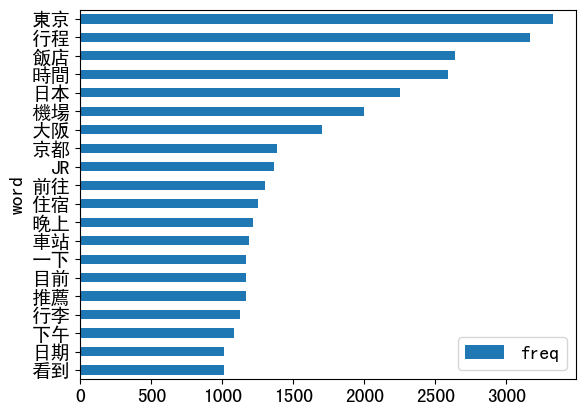

In [12]:
freq_df.iloc[:20].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 2.8 更新停用字字典

In [13]:
# 參數形式手動加入停用字
stopwords_manual = ["謝謝", "一下", "前往", "日期", "問題", "感覺", "目前", "請問", "發現", "直接", "知道", "看到", "現在",  "建議",  "希望", "10", "一點", "機車", "最近", "老闆", "時間",  "購買", "一台", "Yes", "小弟", "XD", "左右", "之後", "這台", "有沒有", "這種"]
stopwords.extend(stopwords_manual)

In [14]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,金魚
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,第四集
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,陪跑
8,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,cmtStatus 推 cmtPoster pinkbest cmtContent 富士山キ...,1.161.122.52,2022-03-03 01:06:17,ptt,場景
27,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,cmtStatus 推 cmtPoster strayfrog cmtContent 第一張...,106.104.85.44,2022-03-05 01:15:00,ptt,旅行
...,...,...,...,...,...,...,...,...,...,...,...
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,17
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,15
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,19
71034,3081,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,[資訊]樂桃11周年優惠活動(日本出發),2023-02-27 14:12:30,yhls,Japan_Travel,cmtStatus 推 cmtPoster Vett cmtContent 成田很有誠意 c...,223.139.225.219,2023-03-06 01:55:21,ptt,28


#### 重新計算詞頻

In [15]:
freq_df_2 = pd.DataFrame({'freq':noStop_df_2.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']  
freq_df_2 = freq_df_2[clist]
freq_df_2

,word,freq
0,東京,3326
1,行程,3168
2,飯店,2641
3,日本,2254
4,機場,2001
...,...,...
54168,排起,1
54169,排買,1
54170,SMART,1
54171,SMF700F,1


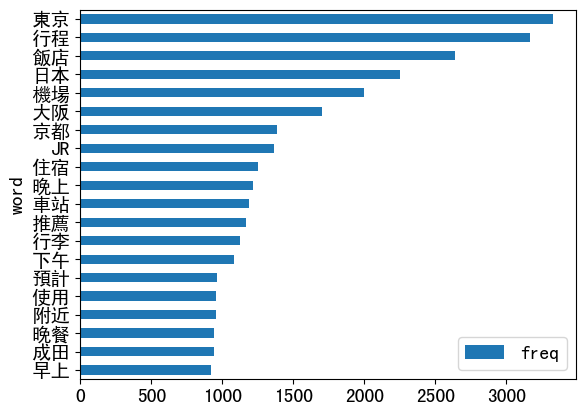

In [16]:
freq_df_2.iloc[:20].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

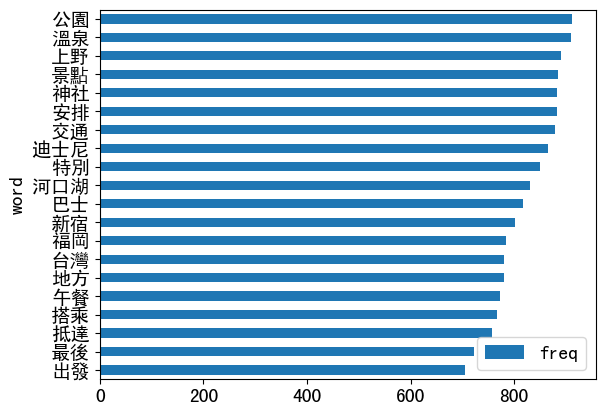

In [17]:
freq_df_2.iloc[20: 40].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 2.9 繪製文字雲

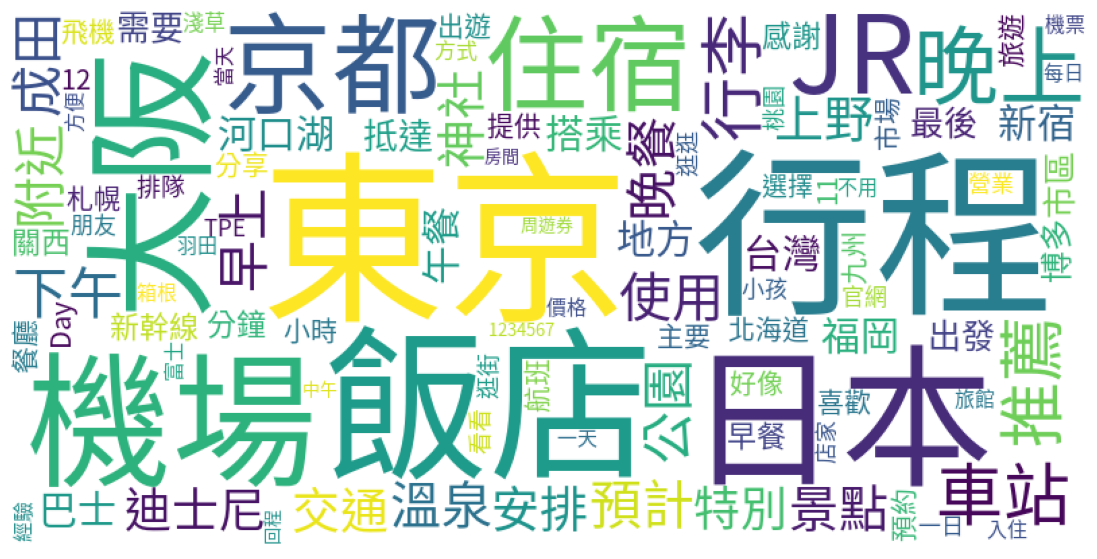

In [18]:
# 詞頻變成dict
freq_dict = freq_df_2.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

# 繪製文字雲
FontPath = 'rawData/SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, max_words=100)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
# plt.show()

# 儲存並顯示文字雲
plt.savefig('pic/wordcloud.png', bbox_inches='tight')

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  

In [19]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [20]:
ptt_df = noStop_df_2.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [21]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           415309
mean     2022-11-30 10:15:09.219749376
min                2022-03-02 10:38:11
25%                2022-10-29 22:20:34
50%                2022-12-14 18:29:42
75%                2023-01-20 13:11:05
max                2023-02-27 14:12:30
Name: artDate, dtype: object

In [22]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

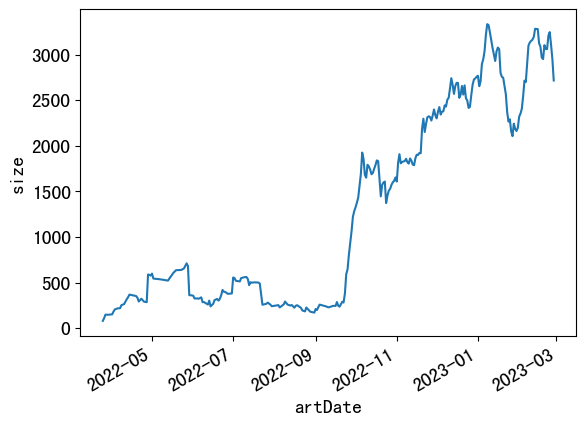

In [23]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

政府於去年的10月13日公告出國解境，討論量明顯從10月中大幅提升了10倍之多

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。。

In [24]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2022-03-02,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,金魚,NaN
1,2022-03-02,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,第四集,NaN
2,2022-03-02,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,陪跑,NaN
3,2022-03-02,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,場景,NaN
4,2022-03-04,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,旅行,NaN
...,...,...,...,...
432067,2023-02-27,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,17,NaN
432068,2023-02-27,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,15,NaN
432069,2023-02-27,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,19,NaN
432070,2023-02-27,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,28,NaN


### 3.3 正負向情緒分數聲量折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [25]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2022-03-02,NaN,4
1,2022-03-04,affect,3
2,2022-03-04,negative,1
3,2022-03-04,positive,2
4,2022-03-04,NaN,51
...,...,...,...
1535,2023-02-25,positive,62
1538,2023-02-26,positive,4
1539,2023-02-26,NaN,343
1537,2023-02-26,affect,5


In [26]:
sentiment_count["sentiments"] == "positive"

0       False
1       False
2       False
3        True
4       False
        ...  
1535     True
1538     True
1539    False
1537    False
1540    False
Name: sentiments, Length: 1541, dtype: bool

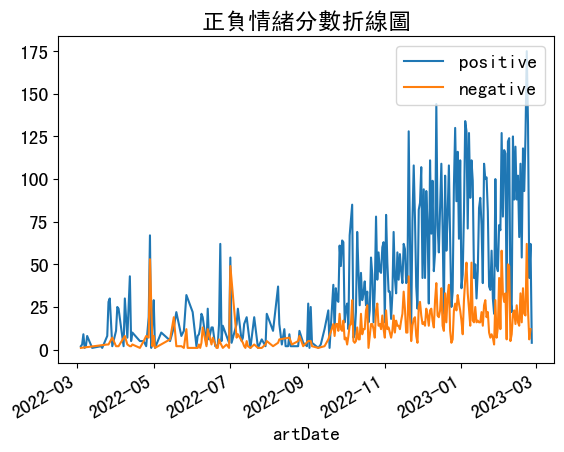

In [27]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")  # 記得加上才能顯示中文
plt.show()

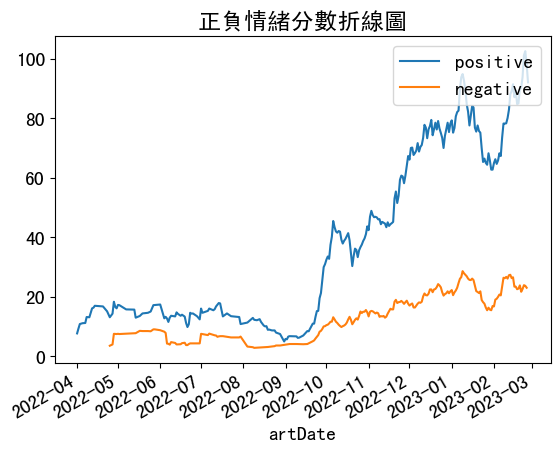

In [28]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")  # 記得加上才能顯示中文
plt.show()

### 3.4 正負向情緒分數比例折線圖

In [29]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2022-03-02,NaN,4,1.000000
1,2022-03-04,affect,3,0.052632
2,2022-03-04,negative,1,0.017544
3,2022-03-04,positive,2,0.035088
4,2022-03-04,NaN,51,0.894737
...,...,...,...,...
1535,2023-02-25,positive,62,0.034812
1538,2023-02-26,positive,4,0.011364
1539,2023-02-26,NaN,343,0.974432
1537,2023-02-26,affect,5,0.014205


In [30]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

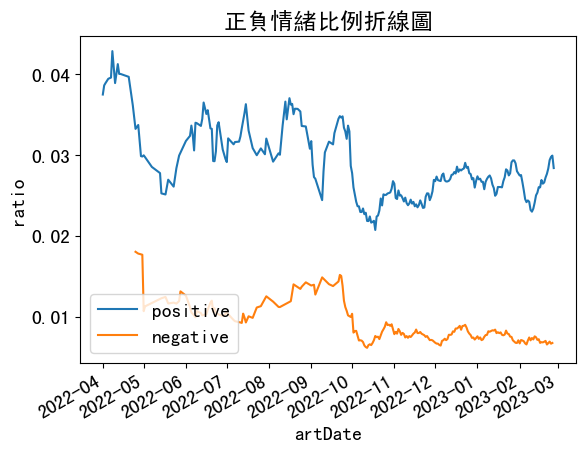

In [31]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [32]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
1516,2023-02-22,positive,175,0.032882
1035,2022-12-12,positive,144,0.031915
1191,2023-01-04,positive,134,0.025207
1522,2023-02-23,positive,132,0.038062
1137,2022-12-27,positive,130,0.032411


#### 2023-02-22 文字雲

In [33]:
date = "2023-02-22"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\2337978106.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))


[('東京', 32),
 ('求婚', 29),
 ('設施', 23),
 ('Ni', 22),
 ('人員', 20),
 ('工作', 20),
 ('日本', 20),
 ('不錯', 18),
 ('園區', 18),
 ('好吃', 18),
 ('順利', 18),
 ('使用', 17),
 ('六花亭', 17),
 ('托馬斯', 17),
 ('新宿', 16),
 ('緊張', 15),
 ('迪士尼', 15),
 ('風見', 15),
 ('大阪', 14),
 ('朋友', 14)]

(-0.5, 799.5, 399.5, -0.5)

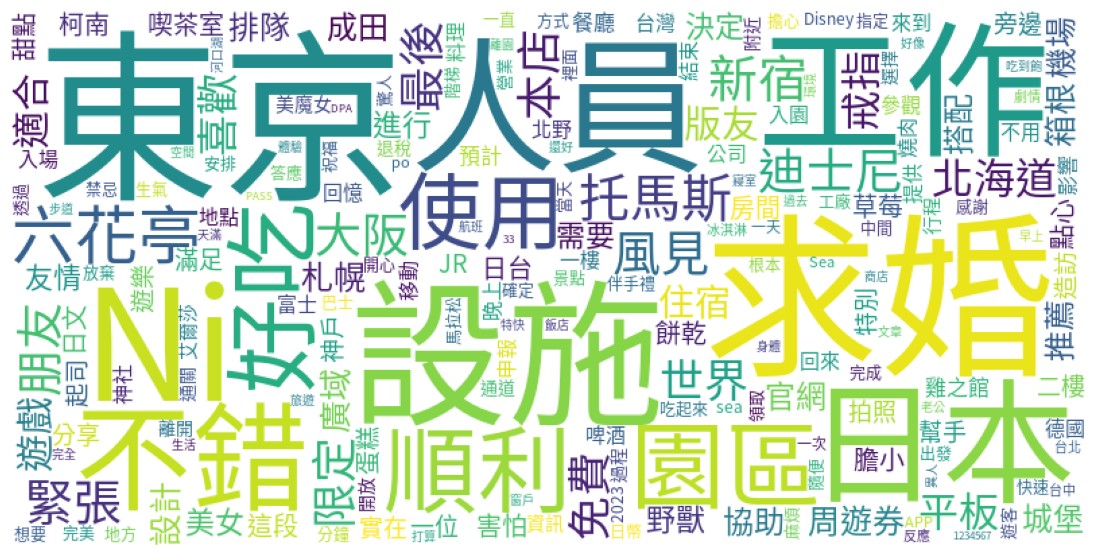

In [34]:
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

2023-02-22 是正面詞彙次數最高的一天。我們可以用文字雲來觀察，日旅版在這天最常出現的正面情緒字有哪些。

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\3288472286.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 799.5, 399.5, -0.5)

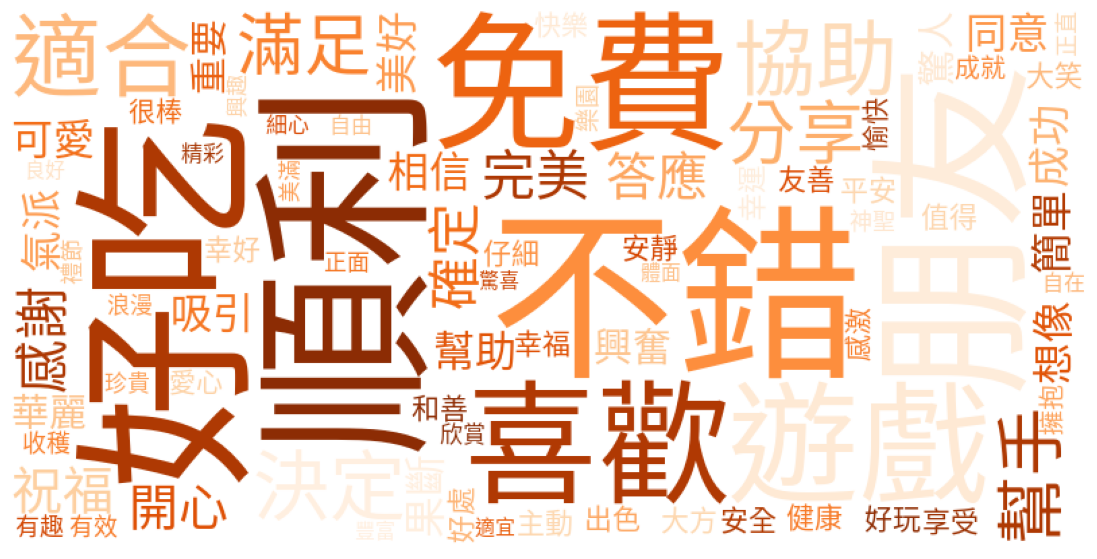

In [35]:
date = "2023-02-22"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\1642541154.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 799.5, 399.5, -0.5)

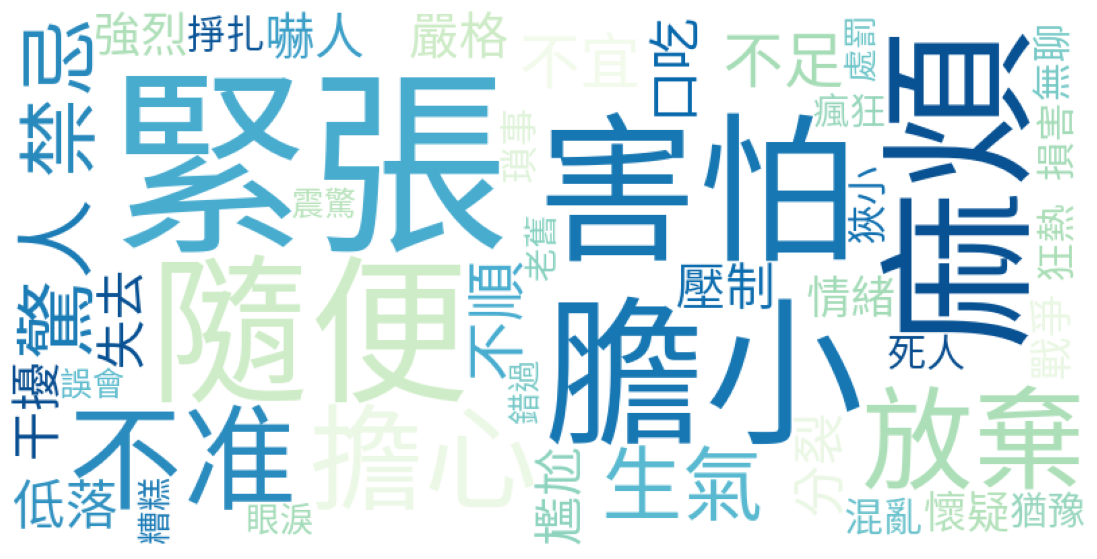

In [36]:
date = "2023-02-22"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [37]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
815,感謝,affect,612
816,感謝,positive,612
207,分享,affect,547
208,分享,positive,547
396,喜歡,affect,530
...,...,...,...
1096,栩栩如生,affect,1
1097,栩栩如生,positive,1
1098,棘手,affect,1
1099,棘手,anx,1


In [38]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

In [39]:
word_of_neg.sort_values(
    ["size"], ascending=False
)

,word,sentiments,size
2032,麻煩,negative,277
986,擔心,negative,191
1369,猶豫,negative,108
1017,放棄,negative,107
1925,隨便,negative,87
...,...,...,...
404,喪志,negative,1
411,嘆息,negative,1
414,嘆氣,negative,1
682,弄壞,negative,1


C:\Users\collin\AppData\Local\Temp\ipykernel_19296\1433489422.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_19296\1433489422.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

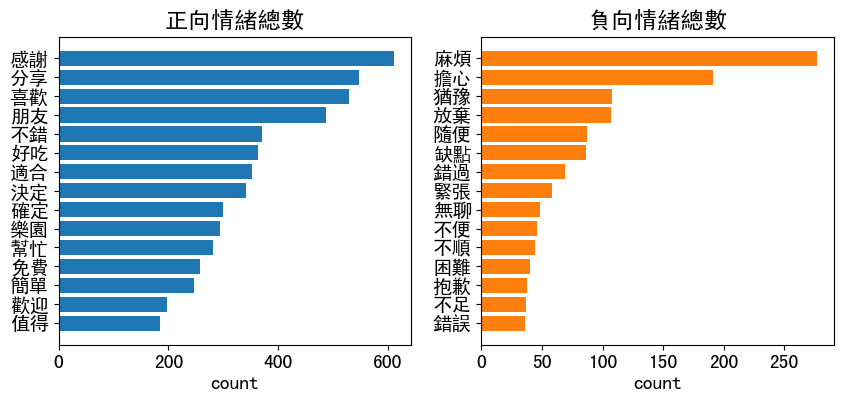

In [40]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 2023-02-22 正負情緒代表字

In [41]:
sentiment_count[sentiment_count["sentiments"] == "negative"].sort_values('size', ascending=False)

,artDate,sentiments,size,ratio
1515,2023-02-22,negative,62,0.011650
1381,2023-02-02,negative,58,0.011777
120,2022-04-28,negative,53,0.011422
1225,2023-01-09,negative,51,0.011226
1197,2023-01-05,negative,51,0.010125
...,...,...,...,...
261,2022-06-20,negative,1,0.014493
200,2022-06-04,negative,1,0.011628
204,2022-06-05,negative,1,0.005263
213,2022-06-07,negative,1,0.002188


In [42]:
date = '2023-02-22'
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\3732538959.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (


,sentiments,word,size
0,negative,不准,2
1,negative,不宜,1
2,negative,不足,1
3,negative,不順,1
4,negative,低落,1


C:\Users\collin\AppData\Local\Temp\ipykernel_19296\1670547556.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_19296\1670547556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


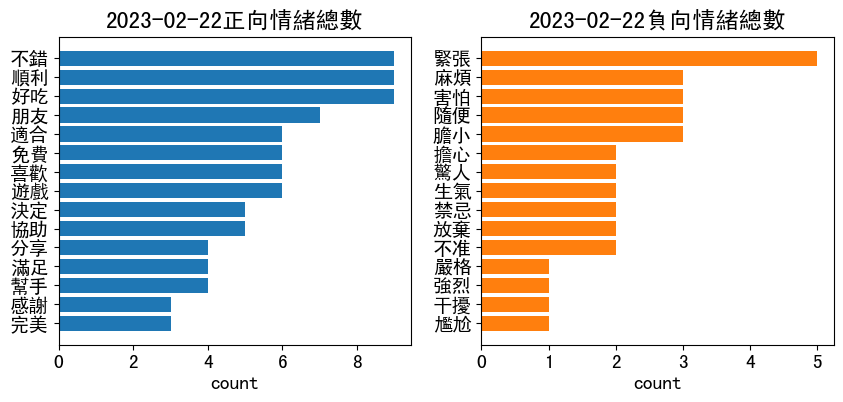

In [43]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數")
ax[0].set_yticklabels(pos["word"])

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數")
ax[1].set_yticklabels(neg["word"])
plt.show()

### 3.7 每日情緒分數趨勢

In [44]:
sentiment_count

,artDate,sentiments,size,ratio
0,2022-03-02,NaN,4,1.000000
1,2022-03-04,affect,3,0.052632
2,2022-03-04,negative,1,0.017544
3,2022-03-04,positive,2,0.035088
4,2022-03-04,NaN,51,0.894737
...,...,...,...,...
1535,2023-02-25,positive,62,0.034812
1538,2023-02-26,positive,4,0.011364
1539,2023-02-26,NaN,343,0.974432
1537,2023-02-26,affect,5,0.014205


In [45]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

In [46]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)

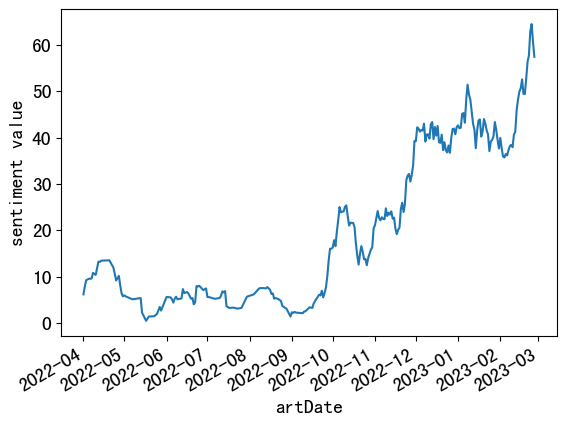

In [47]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

## 4. lexicon-base 情緒分析2

引入所需套件

In [48]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

### 4.1 CKIP 安裝

In [49]:
#data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

In [50]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell =

定義文字清理相關function

In [51]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), str(article).split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [52]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'拉麵': 100.0, '和牛': 100.0, '龍蝦': 100.0, '螃蟹': 100.0, '鰻魚': 100.0, '昆布': 100.0, '壽司': 100.0, '河豚': 100.0, '糰子': 100.0, '串燒': 100.0, '燒烤': 100.0, '牛舌': 100.0, '煎餅': 100.0, '燒肉': 100.0}), (3, {'章魚燒': 100.0, '大阪燒': 100.0, '生魚片': 100.0, '石垣牛': 100.0, '鰻魚飯': 100.0, '蕎麥麵': 100.0, '天婦羅': 100.0, '壽喜燒': 100.0, '烏龍麵': 100.0, '關東煮': 100.0, '咖哩飯': 100.0, '居酒屋': 100.0, '銅鑼燒': 100.0, '炸豬排': 100.0, '醣揚雞': 100.0}), (4, {'白色戀人': 100.0, '煎餅果子': 100.0})]


In [53]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [54]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['演出坂ノ上茜'], ['江戸時代利根川の舟運で栄えた香取市佐原', '今でも小野川を中心に当時を偲ばせる'], ['商家や蔵が軒を連ねています'], ['東京から分成田空港から分で繋がる非日常へ'], ['江戶時代利根川航運繁榮的香取市佐原', '今天也已小野川為中心，排列著保留當時特色的']]
['演出坂ノ上茜', '江戸時代利根川の舟運で栄えた香取市佐原', '今でも小野川を中心に当時を偲ばせる', '商家や蔵が軒を連ねています', '東京から分成田空港から分で繋がる非日常へ']


In [55]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

KeyboardInterrupt: 

In [ ]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,演出,VC
1,1,坂,FW
2,1,ノ,PARENTHESISCATEGORY
3,1,上,Ncd
4,1,茜,Nb


In [ ]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,江戸時代,DATE
1,1,利根川,LOC
2,1,栄えた香取市,GPE
3,1,東京,GPE
4,1,田空港,PERSON


In [ ]:
sentence_table.head()

,system_id,sentence
0,1,演出坂ノ上茜
1,1,江戸時代利根川の舟運で栄えた香取市佐原
2,1,今でも小野川を中心に当時を偲ばせる
3,1,商家や蔵が軒を連ねています
4,1,東京から分成田空港から分で繋がる非日常へ


In [ ]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1517篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1349篇有抓到ner

total posts numbers: 3081
posts have NER: 3056


In [56]:
# 將文章存成csv
pos_table.to_csv('rawData/pos_table_motor.csv', index = False)
entity_table.to_csv('rawData/entity_table_motor.csv', index = False)
sentence_table.to_csv('rawData/sentence_table_motor.csv', index = False)

NameError: name 'pos_table' is not defined

### 4.2 探索分析 - NER

將剛才分析的資料匯入

In [58]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("rawData/pos_table_motor.csv") 
entity_table = pd.read_csv("rawData/entity_table_motor.csv") 
sentence_table = pd.read_csv("rawData/sentence_table_motor.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [59]:
entity_table['ner'].unique()

array(['DATE', 'LOC', 'GPE', 'PERSON', 'FAC', 'TIME', 'ORDINAL', 'NORP',
       'CARDINAL', 'PRODUCT', 'QUANTITY', 'ORG', 'MONEY', 'LANGUAGE',
       'EVENT', 'WORK_OF_ART', 'PERCENT', 'LAW'], dtype=object)

In [60]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
4,GPE,25243
3,FAC,11290
1,DATE,9500
7,LOC,7798
16,TIME,7245
13,PERSON,5559
0,CARDINAL,5451
11,ORG,3738


C:\Users\collin\AppData\Local\Temp\ipykernel_19296\3390866936.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


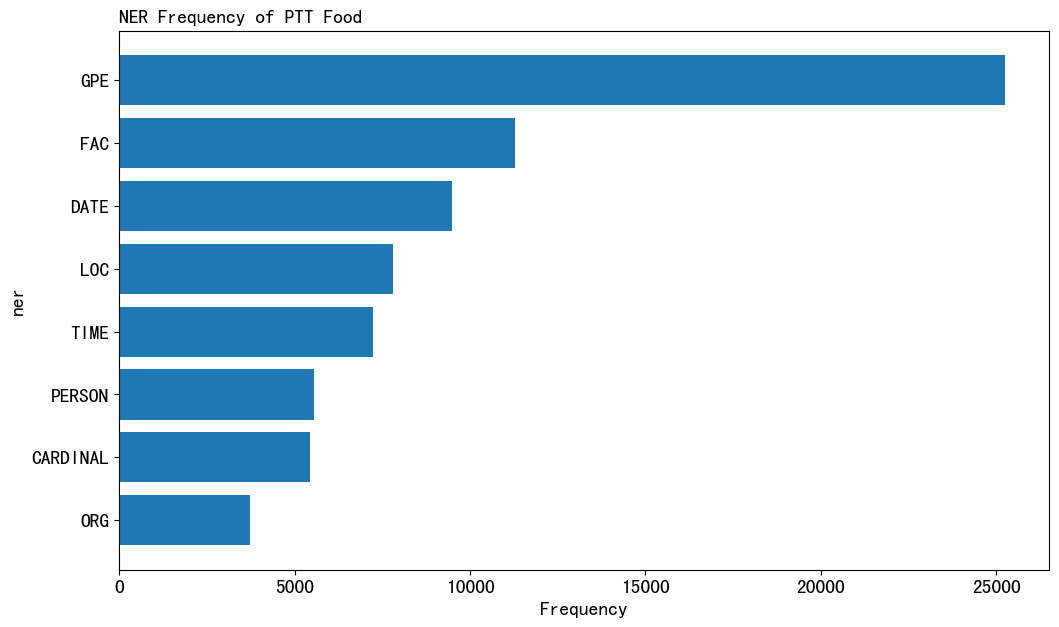

In [61]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\2044175467.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


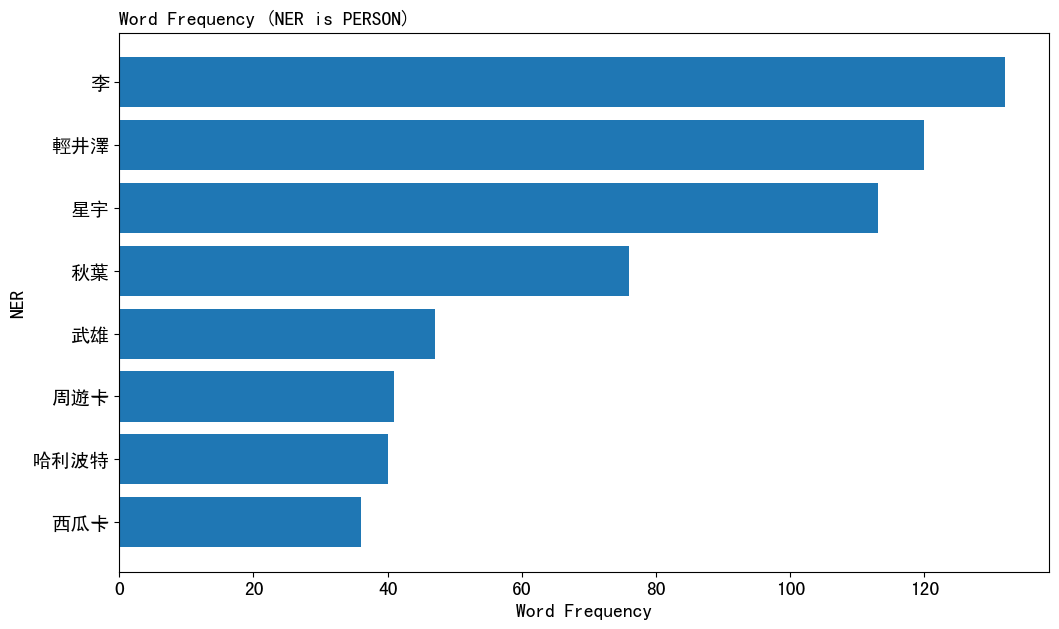

In [62]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的組織(ORG)

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\3690618897.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


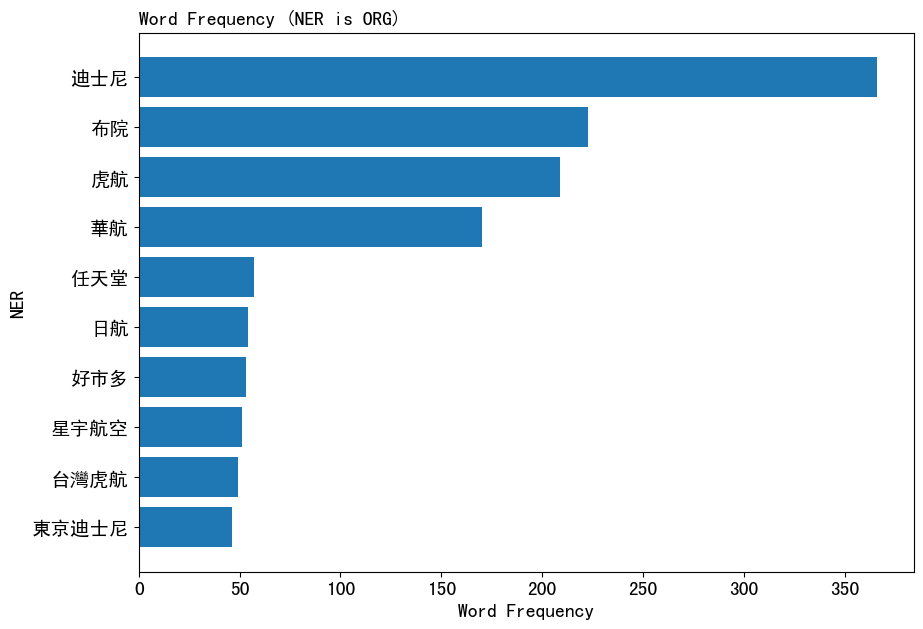

In [63]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\1258504230.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


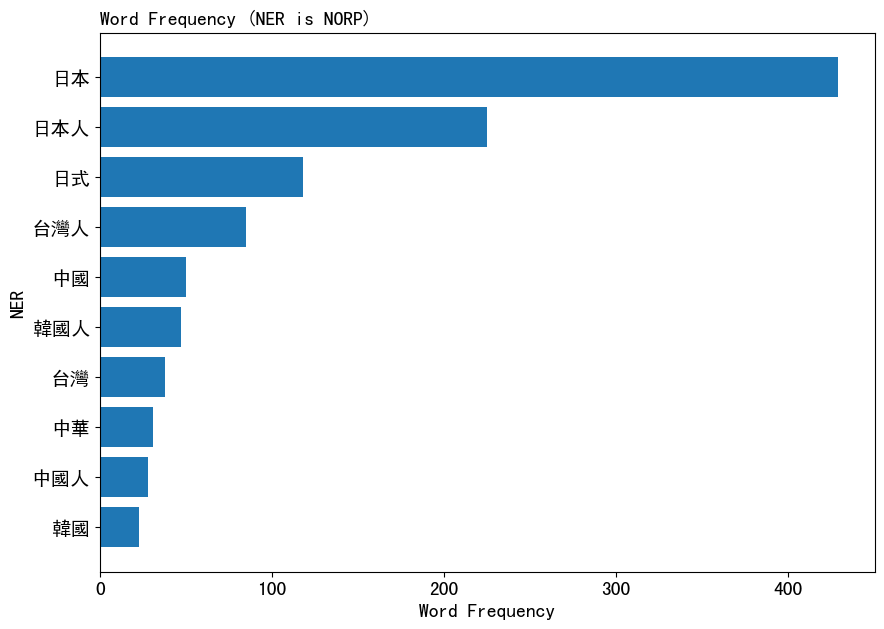

In [64]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

C:\Users\collin\AppData\Local\Temp\ipykernel_19296\638530245.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


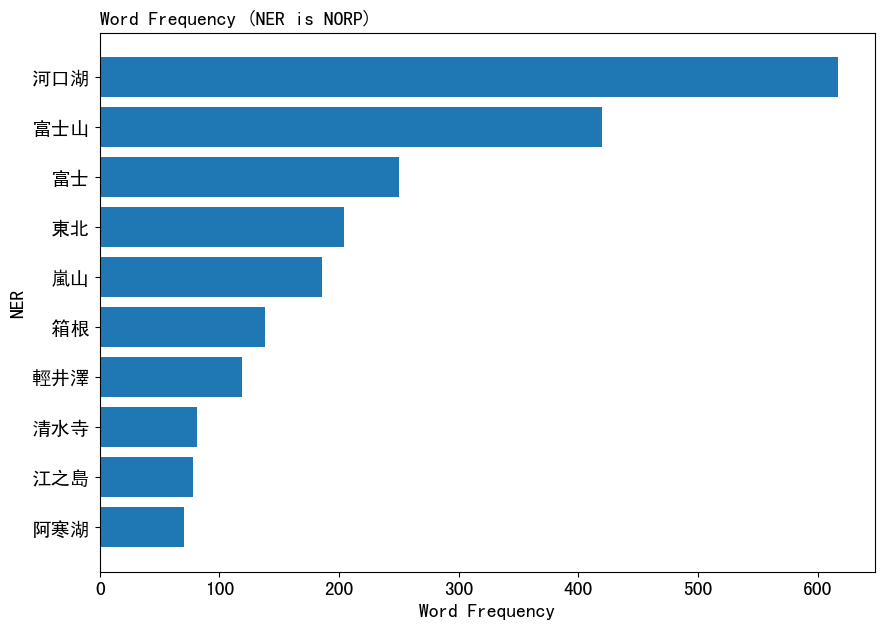

In [65]:
# 篩選ner為名詞的資料
l_noun = ["LOC"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [66]:
keyword_list = ['富士山']
thailand_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True, na=False)]
print(f"{' '.join(keyword_list)}：{thailand_selected.shape[0]}篇相關貼文")
thailand_selected.head()

富士山：201篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
1,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,想請問金魚妻第四集陪跑妻17:48中這個場景是在哪邊？\nhttps://i.imgur.c...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pinkbest"", ""...",1.161.122.52,2022-03-03 01:06:17,ptt
8,9,https://www.ptt.cc/bbs/Japan_Travel/M.16465631...,[冬雪]河口淺間神社遙拜所~天空鳥居&逆富士,2022-03-06 18:39:08,eat2323,Japan_Travel,1. 旅行時間：2022/02/11\n\n2. 旅行地點：山梨縣河口湖 & 河口湖北岸 河...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""HunsKing"", ""...",126.15.33.85,2022-03-07 00:56:53,ptt
15,16,https://www.ptt.cc/bbs/Japan_Travel/M.16471656...,[問題]東京近郊景點請教,2022-03-13 18:00:44,cj6xu6des,Japan_Travel,板上的各位好\n\n想請問在下述條件下大家有什麼好的建議景點\n\n出遊行程\n上午11：0...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""darkness0918...",118.156.235.153,2022-03-14 00:52:57,ptt
22,23,https://www.ptt.cc/bbs/Japan_Travel/M.16480238...,[遊記]ANA全日空羽田=小松來回飛行記,2022-03-23 16:23:20,sdfguiop,Japan_Travel,班機資訊\n\nCarrier - ANA\nFlight No. - NH751 / NH...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""liaoecho"", ""...",220.100.126.134,2022-03-24 00:52:52,ptt
35,36,https://www.ptt.cc/bbs/Japan_Travel/M.16493258...,[遊記]ANA全日空羽田-那霸瀨長島賞機旅,2022-04-07 18:03:42,sdfguiop,Japan_Travel,網誌好讀版：\nhttps://www.wu-fly.com/2022/02/ana-hnd...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pop1014"", ""c...",220.100.119.43,2022-04-08 01:52:52,ptt


In [67]:
keyword_list = ['箱根']
thailand_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True, na=False)]
print(f"{' '.join(keyword_list)}：{thailand_selected.shape[0]}篇相關貼文")
thailand_selected.head()

箱根：101篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
201,202,https://www.ptt.cc/bbs/Japan_Travel/M.16620398...,[遊記]一日單攻富士山吉田路線,2022-09-01 21:43:44,TWcannon,Japan_Travel,登山日期：2022/08/31\n上山時間：6:20\n登頂時間：12:40 (上山6小時2...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""cvit"", ""cmtC...",126.168.153.116,2022-09-02 01:47:58,ptt
224,225,https://www.ptt.cc/bbs/Japan_Travel/M.16637535...,[問題]11月底箱根or河口湖一日遊選擇,2022-09-21 17:46:04,awihsataw168,Japan_Travel,１． 出遊日期： 11/28-12/03中某一天\n\n２． 行程安排：\n原先只有規劃在都...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a5687920"", ""...",27.52.222.49,2022-09-22 01:51:14,ptt
239,240,https://www.ptt.cc/bbs/Japan_Travel/M.16639104...,Re:[問題]觀光客在日本染疫怎麼辦呢？,2022-09-23 13:20:31,janejane,Japan_Travel,我應該可以稍稍解答這個問題，不過也只是上個月的資訊就是了。\n\n真心不知道是在哪被傳染的，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a5687920"", ""...",123.194.176.126,2022-09-24 01:51:28,ptt
262,263,https://www.ptt.cc/bbs/Japan_Travel/M.16641097...,[問題]東京市區住宿行李寄放問題,2022-09-25 20:41:41,Mengfanwei,Japan_Travel,大家好~ 先預祝大家都順利機票飯店訂好訂滿~\n\n 我想請教一下 這次去東京主要帶小孩長...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Falcona"", ""c...",36.231.113.227,2022-09-26 01:44:45,ptt
295,296,https://www.ptt.cc/bbs/Japan_Travel/M.16642608...,[問題]東京輕井澤(近郊景點)建議,2022-09-27 14:40:48,LonGen,Japan_Travel,下午好~ 幾個問題想請教版友提供經驗建議\n\n 成員: 爸媽(愛自由行算耐走但不太能爬樓...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""russellyang""...",None,2022-09-28 01:44:55,ptt


### 4.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [68]:
pos_table['pos'].unique()

array(['VC', 'FW', 'PARENTHESISCATEGORY', 'Ncd', 'Nb', 'Nd', 'Na', 'Nc',
       'A', 'Ng', 'Neu', 'Cbb', 'VG', 'VHC', 'DE', 'D', 'COMMACATEGORY',
       'Di', 'Caa', 'P', 'Nf', 'VCL', 'VE', 'Nv', 'Nep', 'SHI', 'VH', 'T',
       'Nes', 'Neqa', 'Nh', 'VA', 'Dfa', 'VL', 'V_2', 'VJ', 'VK', 'VF',
       'VB', 'Da', 'I', 'Dk', 'Cab', 'VD', 'Neqb', 'VAC', 'Dfb', 'VI',
       'DM', 'PERIODCATEGORY', 'Cba', 'ETCCATEGORY', 'DASHCATEGORY',
       'COLONCATEGORY', 'EXCLAMATIONCATEGORY', 'PAUSECATEGORY'],
      dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [69]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
18,Na,203266
5,D,115488
20,Nc,98913
39,VC,81166
45,VH,60814
7,DE,50560
16,FW,42373
32,P,35398
36,VA,35219
28,Nf,29511


C:\Users\collin\AppData\Local\Temp\ipykernel_19296\2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


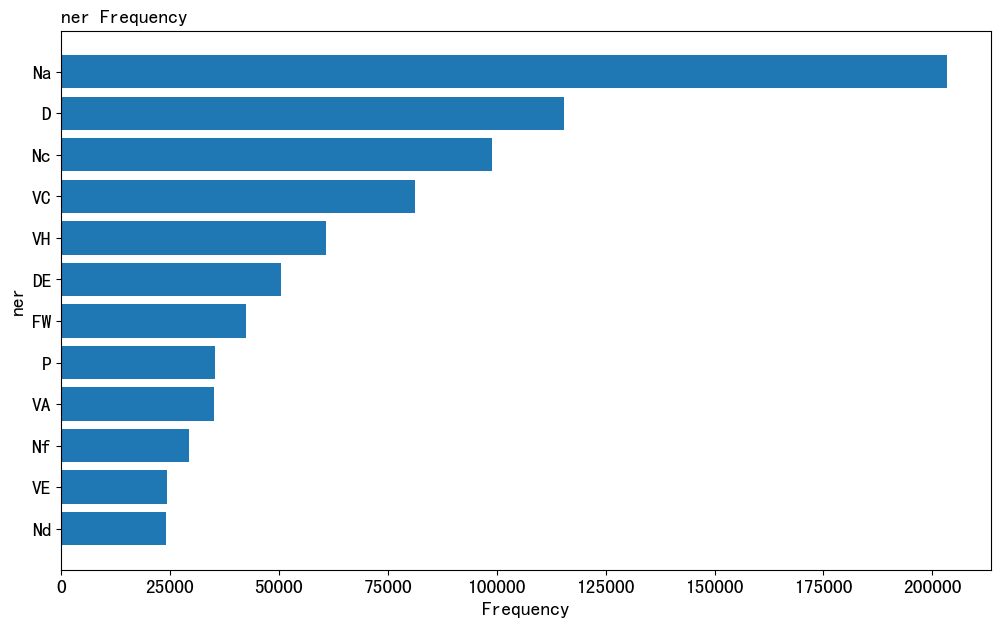

In [70]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論吃到飽時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [71]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
4201,迪士尼,903
3645,羽田,384
1506,富士,360
3930,虎航,274
2277,星宇,215
2761,武雄,198
2919,淺草,156
2393,李,144
368,任天堂,127
3895,藏王,124


C:\Users\collin\AppData\Local\Temp\ipykernel_19296\502700507.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


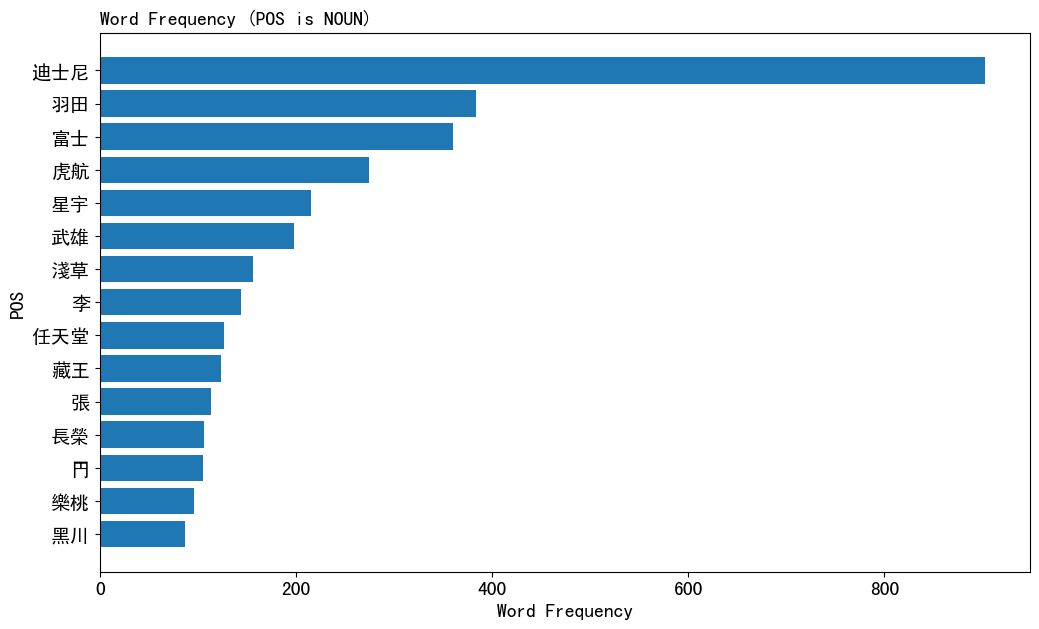

In [72]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)
+ 我們可以找出談論吃到飽時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [73]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
2303,推薦,1410
177,使用,1208
2454,搭乘,955
5460,預約,647
5010,造訪,621
5113,選擇,617
4708,購買,585
5559,體驗,479
727,參考,453
800,吃完,448


C:\Users\collin\AppData\Local\Temp\ipykernel_19296\1955970811.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


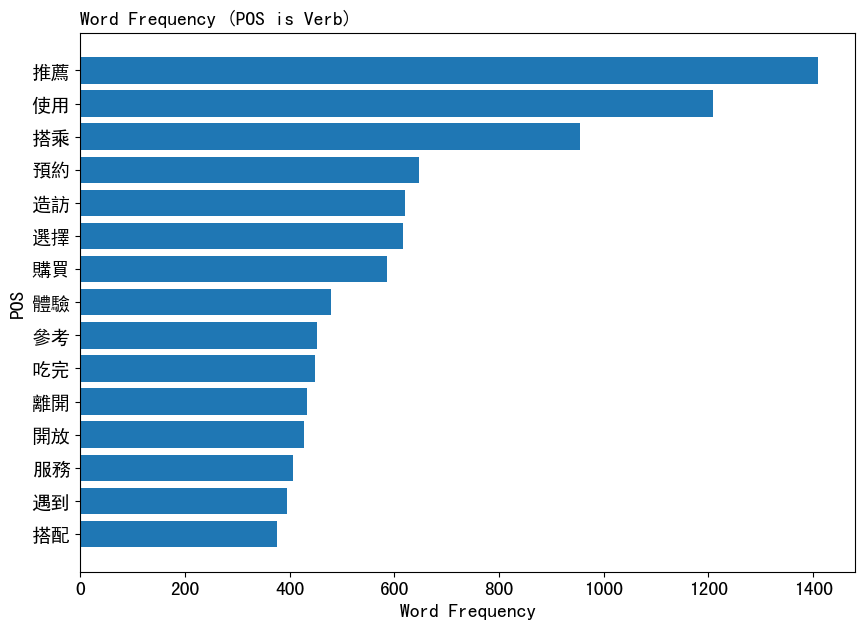

In [74]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is Verb)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

## 5. 利用SnowNLP進行情緒分析

In [75]:
from snownlp import SnowNLP

In [76]:
sentence_table = pd.read_csv("rawData/sentence_table_motor.csv") #匯資料

sentiment_date = pd.merge(sentence_table,thailand_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
11093,202,登山日期//,2022-09-01 21:43:44,ptt
11094,202,上山時間,2022-09-01 21:43:44,ptt
11095,202,登頂時間上山小時分鐘,2022-09-01 21:43:44,ptt
11096,202,下山時間,2022-09-01 21:43:44,ptt
11097,202,抵達時間下山小時分鐘,2022-09-01 21:43:44,ptt


In [77]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
11093,202,登山日期//,2022-09-01 21:43:44,ptt,0.373194
11094,202,上山時間,2022-09-01 21:43:44,ptt,0.098053
11095,202,登頂時間上山小時分鐘,2022-09-01 21:43:44,ptt,0.258322
11096,202,下山時間,2022-09-01 21:43:44,ptt,0.096052
11097,202,抵達時間下山小時分鐘,2022-09-01 21:43:44,ptt,0.697108


In [78]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    5.182000e+03
mean     3.990360e-01
std      3.034390e-01
min      7.859615e-09
25%      1.289415e-01
50%      3.457466e-01
75%      6.202296e-01
max      9.999968e-01
Name: sentimentValue, dtype: float64

<Axes: >

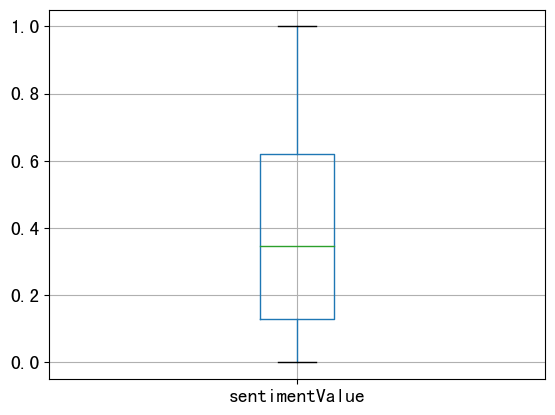

In [79]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [80]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2022-09,0.332312
1,2022-10,0.406766
2,2022-11,0.403672
3,2022-12,0.399131
4,2023-01,0.410637
5,2023-02,0.406727


C:\Users\collin\AppData\Local\Temp\ipykernel_19296\2520951907.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


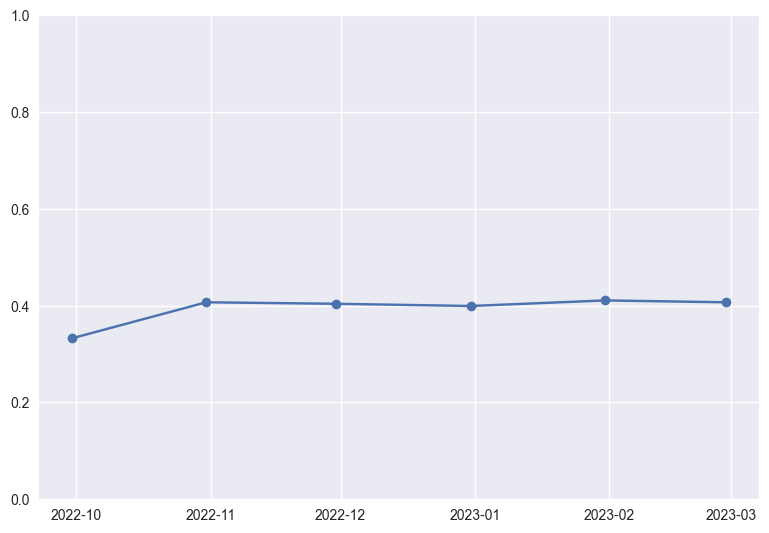

In [81]:
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

### 詞彙探索
從上圖中可以發現 2019年4月的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [82]:
filter_sentiment = sent_date[sent_date['artDate']=='2023-02']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.6]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
108375,2675,去程搭乘酷航出發抵達,2023-02,ptt,0.997769
108376,2675,回程搭乘酷航出發抵達,2023-02,ptt,0.999255
108377,2675,這趟的成員是幾歲的我跟我姊決定要帶的爸媽去趟自由行，爸媽身體算蠻健康的,2023-02,ptt,0.936354
108378,2675,都還挺能走，現在都要他們盡量每天至少走萬五步當訓練，但由於以往我去日本都是自,2023-02,ptt,0.997315
108381,2675,行程規劃,2023-02,ptt,0.713669


In [83]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,2675,0.997769,///
1,2675,0.997769,去程
2,2675,0.997769,搭乘
3,2675,0.997769,酷航
4,2675,0.997769,出發


In [84]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [85]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

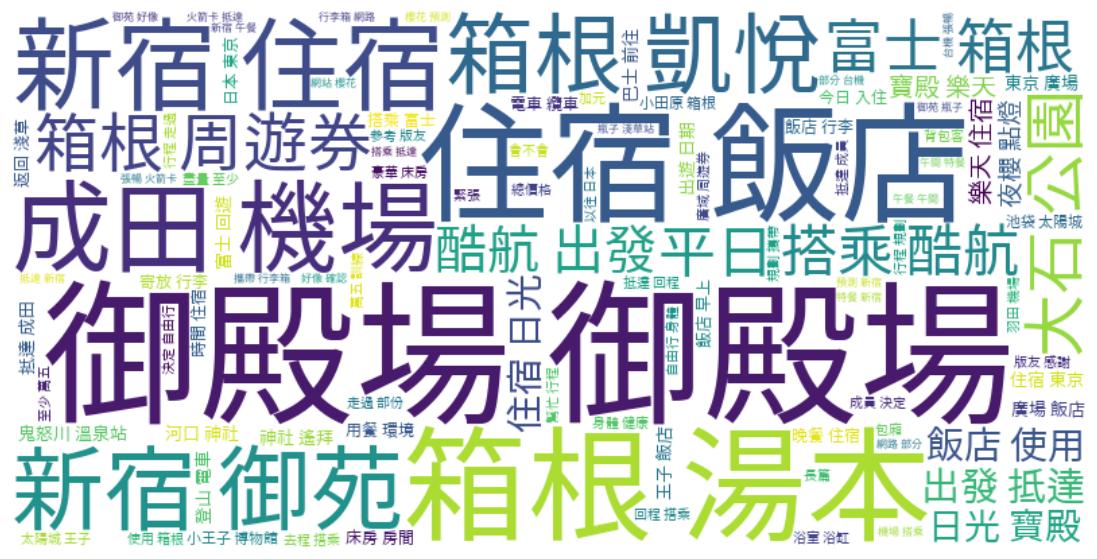

In [86]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(("謝謝", "一下", "問題", "感覺", "目前", "請問", "發現", "直接", "知道", "看到", "現在", "車子", "建議", "車主", "希望", "10", "一點"))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

# 看 箱根 的討論趨勢

# TF-IDF

### 計算每篇文章的總詞彙數與各個詞彙數

In [87]:
MetaData = df.copy()
MetaData.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt
1,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,想請問金魚妻第四集陪跑妻17:48中這個場景是在哪邊？\nhttps://i.imgur.c...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pinkbest"", ""...",1.161.122.52,2022-03-03 01:06:17,ptt
2,3,https://www.ptt.cc/bbs/Japan_Travel/M.16462912...,Fw:[資訊]本週六(3/5)台南免費日本群馬縣旅遊講座,2022-03-03 15:08:04,setsutetsuya,Japan_Travel,作者: setsutetsuya (我吃故我在) 看板: Tainan\n標題: [活動] ...,[],210.69.40.253,2022-03-04 01:17:55,ptt
3,4,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,[冬雪]北海道,2022-03-04 17:22:10,isdnwind,Japan_Travel,1. 旅行時間：2020.03\n\n2. 旅行地點：北海道\n\n3. 圖文摘要：\nht...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""strayfrog"", ...",106.104.85.44,2022-03-05 01:15:00,ptt
4,5,https://www.ptt.cc/bbs/Japan_Travel/M.16463905...,[冬雪]青森37年未見的大雪與雪中不良風石獅,2022-03-04 18:42:26,Sherlock56,Japan_Travel,1. 旅行時間：（年月即可）\n\n2022年1月\n\n2. 旅行地點：\n\n青森\n\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""vV070413"", ""...",121.109.164.134,2022-03-05 01:15:00,ptt


In [88]:
# 移除網址格式
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
# 只留下中文字
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...
1,2,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,[問題]金魚妻第四集的富士山場景,2022-03-02 10:38:11,racoon151,Japan_Travel,想請問金魚妻第四集陪跑妻17:48中這個場景是在哪邊？\nhttps://i.imgur.c...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pinkbest"", ""...",1.161.122.52,2022-03-03 01:06:17,ptt,想請問金魚妻第四集陪跑妻中這個場景是在哪邊富士山好大一仙喔另外想請問各個達人劇中那個豪宅公寓...
2,3,https://www.ptt.cc/bbs/Japan_Travel/M.16462912...,Fw:[資訊]本週六(3/5)台南免費日本群馬縣旅遊講座,2022-03-03 15:08:04,setsutetsuya,Japan_Travel,作者: setsutetsuya (我吃故我在) 看板: Tainan\n標題: [活動] ...,[],210.69.40.253,2022-03-04 01:17:55,ptt,作者我吃故我在看板標題活動本週六市立圖書館免費日本旅遊講座時間東京近郊秘境群馬縣水上町四季繪...


In [89]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [90]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [91]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\dict\dict.txt.big ...
Loading model from cache C:\Users\collin\AppData\Local\Temp\jieba.u0caaf84a2321cd627dbb38b2e15eb981.cache
Loading model cost 0.627 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,演出
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,坂上
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,時代


In [92]:
# 每篇文章的總詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,39
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461886...,14
2,https://www.ptt.cc/bbs/Japan_Travel/M.16462912...,92
3,https://www.ptt.cc/bbs/Japan_Travel/M.16463857...,239
4,https://www.ptt.cc/bbs/Japan_Travel/M.16463905...,257
...,...,...
3076,https://www.ptt.cc/bbs/Japan_Travel/M.16773401...,95
3077,https://www.ptt.cc/bbs/Japan_Travel/M.16773423...,197
3078,https://www.ptt.cc/bbs/Japan_Travel/M.16773446...,200
3079,https://www.ptt.cc/bbs/Japan_Travel/M.16773464...,62


In [93]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1
...,...,...,...
390454,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,說明,1
390455,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,起高雄,1
390456,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,週年,1
390457,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,部分,3


In [94]:
moto_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
moto_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2,39
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1,39
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1,39
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1,39
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1,39
...,...,...,...,...
390454,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,說明,1,83
390455,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,起高雄,1,83
390456,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,週年,1,83
390457,https://www.ptt.cc/bbs/Japan_Travel/M.16774783...,部分,3,83


### 計算tf-idf值

In [95]:
# 計算tf
moto_words_tf_idf = moto_words.assign(tf = moto_words.iloc[:,2]/moto_words.iloc[:,3])
moto_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2,39,0.051282
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1,39,0.025641
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1,39,0.025641
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1,39,0.025641
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1,39,0.025641


In [96]:
# 計算每個詞彙出現在幾篇文章中
idf_df = moto_words.groupby(['word'],as_index=False).size()
moto_words_tf_idf = moto_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
moto_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2,39,0.051282,126
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1,39,0.025641,281
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1,39,0.025641,59
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1,39,0.025641,58
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1,39,0.025641,28


In [97]:
# 計算idf
food_words_tf_idf = moto_words_tf_idf.assign(idf = moto_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

food_words_tf_idf = food_words_tf_idf.drop(labels=['size'],axis=1)
food_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2,39,0.051282,1.388321
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1,39,0.025641,1.039985
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1,39,0.025641,1.717840
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1,39,0.025641,1.725264
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1,39,0.025641,2.041534


In [98]:
# 計算tf*idf
moto_words_tf_idf = moto_words_tf_idf.assign(tf_idf = moto_words_tf_idf.iloc[:,4] * moto_words_tf_idf.iloc[:,5])
moto_words_tf_idf.head()

,artUrl,word,count,total,tf,size,tf_idf
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2,39,0.051282,126,6.461538
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1,39,0.025641,281,7.205128
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1,39,0.025641,59,1.512821
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1,39,0.025641,58,1.487179
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1,39,0.025641,28,0.717949


In [99]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = moto_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))
group

artUrl  \
artUrl                                                                                                         
https://www.ptt.cc/bbs/Japan_Travel/M.164610737... 19      https://www.ptt.cc/bbs/Japan_Travel/M.16461073...   
                                                   20      https://www.ptt.cc/bbs/Japan_Travel/M.16461073...   
                                                   5       https://www.ptt.cc/bbs/Japan_Travel/M.16461073...   
                                                   15      https://www.ptt.cc/bbs/Japan_Travel/M.16461073...   
                                                   14      https://www.ptt.cc/bbs/Japan_Travel/M.16461073...   
...                                                                                                      ...   
https://www.ptt.cc/bbs/Japan_Travel/M.167747835... 390443  https://www.ptt.cc/bbs/Japan_Travel/M.16774783...   
                                                   390426  https://www.ptt.cc/bbs/Japan_Travel/M.16774783...   
                                                   390436  https://www.ptt.cc/bbs/Japan_Travel/M.16774783...   
                                                   390430  https://www.ptt.cc/bbs/Japan_Travel/M.16774783...   
                                                   390444  https://www.ptt.cc/bbs/Japan_Travel/M.16774783...   

                                                          word  count  total  \
artUrl                                                                         
https://www.ptt.cc/bbs/Japan_Travel/M.164610737... 19       東京      2     39   
                                                   20       機場      1     39   
                                                   5        分鐘      2     39   
                                                   15       抵達      1     39   
                                                   14       成田      1     39   
...                                                        ...    ...    ...   
https://www.ptt.cc/bbs/Japan_Travel/M.167747835... 390443   日本      4     83   
                                                   390426   出發      8     83   
                                                   390436   大阪      5     83   
                                                   390430   台灣      6     83   
                                                   390444   時間      2     83   

                                                                 tf  size  \
artUrl                                                                      
https://www.ptt.cc/bbs/Japan_Travel/M.164610737... 19      0.051282  1573   
                                                   20      0.025641   928   
                                                   5       0.051282   436   
                                                   15      0.025641   558   
                                                   14      0.025641   495   
...                                                             ...   ...   
https://www.ptt.cc/bbs/Japan_Travel/M.167747835... 390443  0.048193  1340   
                                                   390426  0.096386   568   
                                                   390436  0.060241   810   
                                                   390430  0.072289   443   
                                                   390444  0.024096  1262   

                                                              tf_idf  
artUrl                                                                
https://www.ptt.cc/bbs/Japan_Travel/M.164610737... 19      80.666667  
                                                   20      23.794872  
                                                   5       22.358974  
                                                   15      14.307692  
                                                   14      12.692308  
...                                                              ...  
https://www.ptt.cc/bbs/Japan_Trave

In [100]:
group.loc[:,["word","tf_idf"]][0:15]

word      tf_idf
artUrl                                                                
https://www.ptt.cc/bbs/Japan_Travel/M.164610737... 19   東京   80.666667
                                                   20   機場   23.794872
                                                   5    分鐘   22.358974
                                                   15   抵達   14.307692
                                                   14   成田   12.692308
https://www.ptt.cc/bbs/Japan_Travel/M.164618869... 39   東京  112.357143
                                                   38  富士山   14.428571
                                                   34   場景    3.571429
                                                   42   達人    2.000000
                                                   33   劇中    1.214286
https://www.ptt.cc/bbs/Japan_Travel/M.164629128... 73   日本   43.695652
                                                   77   東京   34.195652
                                                   71   旅行   15.326087
                                                   75   時間   13.717391
                                                   83   活動    8.804348

In [101]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(moto_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
455,東京,1531
645,行程,1297
406,日本,1235
421,時間,1150
469,機場,741
0,一下,732
554,目前,681
256,大阪,677
817,飯店,673
678,謝謝,660


## 透過結巴斷詞與N-gram幫助建立字典

In [102]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [103]:
moto_bigram = MetaData.copy()

moto_bigram["word"] = moto_bigram.sentence.apply(bigram_getToken)
moto_bigram = moto_bigram.explode('word')
moto_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,演出 坂上
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,坂上 時代
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,時代 利根


### 統計最常出現的bigram組合

In [104]:
# 計算每個組合出現的次數
food_bigram_count = moto_bigram.groupby(["word"],as_index=False).size()
food_bigram_count.head()

,word,size
0,一丁 倫敦,1
1,一丁 商店,1
2,一丁 噴氣,1
3,一丁 小記,1
4,一丁 本命,1


In [105]:
# 清除包含英文或數字的bigram組合
fb_filter = list(food_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
368322,造訪 日期,478
171891,成田 機場,444
64629,出遊 日期,438
240582,每日 行程,379
273271,環球 影城,322
267804,特別 希望,280
227066,東京 車站,277
388858,關西 機場,274
163931,徵人 類別,241
227087,東京 迪士尼,190


### Trigram

In [106]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [107]:
food_trigram = MetaData.copy()

food_trigram["word"] = food_trigram.sentence.apply(trigram_getToken)
food_trigram = food_trigram.explode('word')
food_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,演出 坂上 時代
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,坂上 時代 利根
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,時代 利根 川舟


#### 統計最常出現的trigram組合

In [108]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
fb_filter = list(food_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_trigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
202077,徵人 類別 旅伴,144
282923,東京 廣域 周遊,109
501333,類別 旅伴 性別,105
244872,旅伴 性別 徵求,82
333140,版食記 連結 參考,80
103782,參考 簡單 筆記,79
459214,連結 參考 簡單,79
80442,出遊 日期 每日,74
250412,日期 每日 行程,74
218583,抵達 成田 機場,68


In [109]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [110]:
# 再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)
word_count2.head(10)

,artUrl,word,count
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1
5,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分鐘,2
6,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,利根,2
7,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,商家,2
8,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,坂上,1
9,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,小野,2


# 建立Ngram預測模型

In [111]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()


In [112]:
def ngram(documents, N=2):
    ngram_prediction = {}
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [113]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

### 預測下一個會出現的字

In [114]:
text = '御殿場'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 富士, probability: 0.0488
next word: 山中湖, probability: 0.0488
next word: 巴士, probability: 0.0488
next word: 箱根, probability: 0.0488
next word: 折扣, probability: 0.0244


In [115]:
text = '箱根'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 周遊, probability: 0.122
next word: 湯本, probability: 0.0855
next word: 神社, probability: 0.0754
next word: 河口, probability: 0.0448
next word: 箱根, probability: 0.0346


## Bigram視覺化

In [116]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [117]:
moto_bigram2 = MetaData.copy()
moto_bigram2["word"] = moto_bigram2.sentence.apply(bigram_getToken_dict)

In [118]:
food_bigram2 = moto_bigram2.explode('word')
food_bigram2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,演出 坂上
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,坂上 時代
0,1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,[資訊]香取市觀光PR動畫,2022-03-01 12:02:51,rainjuly,Japan_Travel,演出：坂ノ上茜\n\n江戸時代、利根川の舟運で栄えた香取市佐原。今でも小野川を中心に、当時を...,[],101.12.49.134,2022-03-02 01:10:01,ptt,演出坂上茜江戸時代利根川舟運栄香取市佐原今小野川中心当時偲商家蔵軒連東京分成田空港分繋非日常...,時代 利根


In [119]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('造訪', '日期'), 478),
 (('成田', '機場'), 444),
 (('出遊', '日期'), 438),
 (('每日', '行程'), 379),
 (('環球', '影城'), 322)]

In [120]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [121]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

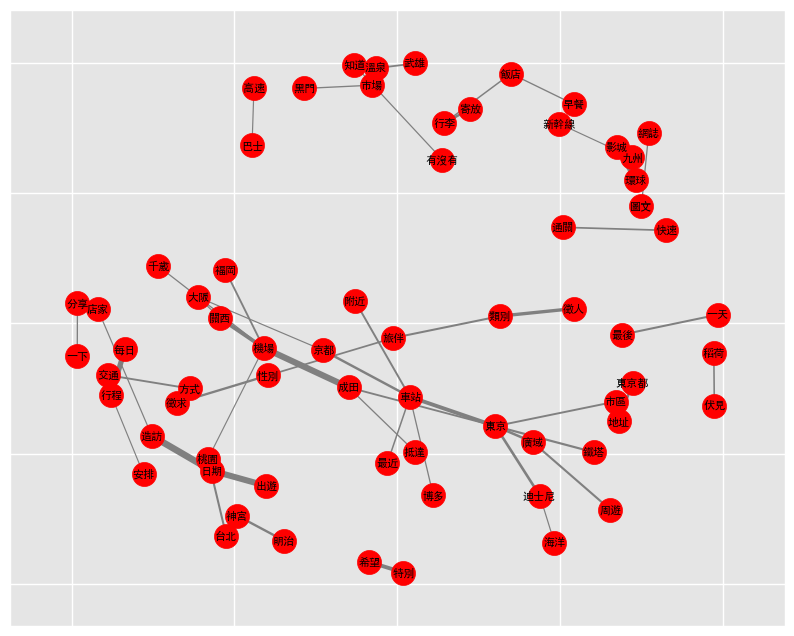

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='red',
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family='SimHei')
    
plt.show()

## Pairwise corrslation

In [123]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}
# b.items()

In [124]:
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())

In [125]:
# 每個bigram組合的次數
bigram_df.head()

,word,word2,n
0,造訪,日期,478
1,成田,機場,444
2,出遊,日期,438
3,每日,行程,379
4,環球,影城,322


In [126]:
# 詞彙在各文章中出現的次數
word_count2.head()

,artUrl,word,count
0,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,中心,2
1,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,今天,1
2,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,保留,1
3,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,倉庫,1
4,https://www.ptt.cc/bbs/Japan_Travel/M.16461073...,分成,1


In [127]:
#計算phi值
def phi_cor(df):
    # total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    # total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    # 有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [128]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [129]:
bigram_df.head(20)

,word,word2,n,cor
0,造訪,日期,478,0.513444
1,成田,機場,444,0.371641
2,出遊,日期,438,0.532767
3,每日,行程,379,0.399184
4,環球,影城,322,0.866508
5,特別,希望,280,0.378407
6,東京,車站,277,0.019319
7,關西,機場,274,0.263836
8,徵人,類別,241,0.971134
9,東京,迪士尼,190,0.216182


##  和詞彙相關性最高的10個詞彙

In [136]:
ice_sum = bigram_df[(bigram_df["word"]=="箱根")].sort_values(by=['cor'], ascending = False).head(10)
taste_sum = bigram_df[(bigram_df["word"]=="御殿場")].sort_values(by=['cor'], ascending = False).head(10)

c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28271 (\N{CJK UNIFIED IDEOGRAPH-6E6F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27827 (\N{CJK UNIFIED IDEOGRAPH-6CB3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 216

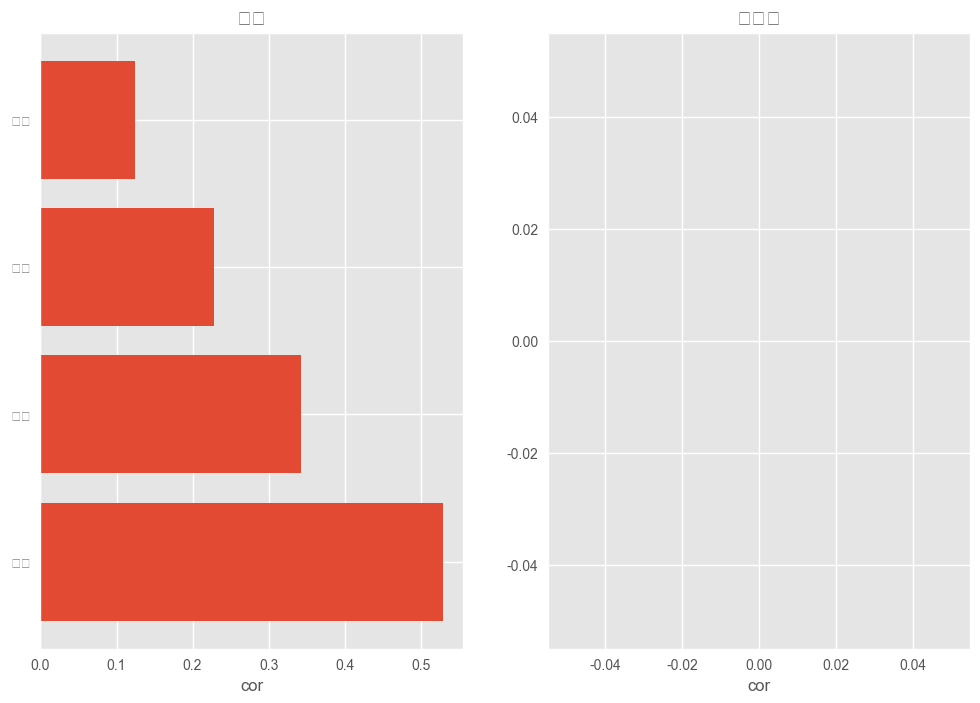

In [137]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('箱根')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])

plt.subplot(122)
plt.title('御殿場')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")


plt.show()